In [ ]:
pip install diffrax equinox optax

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.6/163.6 kB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 175.2/175.2 kB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.7/40.7 kB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.5/66.5 kB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.5/81.5 kB 4.2 MB/s eta 0:00:00


In [ ]:
import time
import diffrax
import equinox as eqx  # https://github.com/patrick-kidger/equinox
import jax
import jax.nn as jnn
import jax.numpy as jnp
import jax.random as jr
import matplotlib.pyplot as plt
import optax  # https://github.com/deepmind/optax

In [ ]:
class Func(eqx.Module):
    mlp: eqx.nn.MLP

    def __init__(self, data_size, width_size, depth, *, key, **kwargs):
        super().__init__(**kwargs)
        self.mlp = eqx.nn.MLP(
            in_size=data_size,
            out_size=data_size,
            width_size=width_size,
            depth=depth,
            activation=jnn.softplus,
            key=key,
        )

    def __call__(self, t, y, args):
        return self.mlp(y)

class NeuralODE(eqx.Module):
    func: Func

    def __init__(self, data_size, width_size, depth, *, key, **kwargs):
        super().__init__(**kwargs)
        self.func = Func(data_size, width_size, depth, key=key)

    def __call__(self, ts, y0):
        #print(f"y0: {y0}")
        solution = diffrax.diffeqsolve(
            diffrax.ODETerm(self.func),
            diffrax.Tsit5(),
            t0=ts[0],
            t1=ts[-1],
            dt0=ts[1] - ts[0],
            y0=y0,
            stepsize_controller=diffrax.PIDController(rtol=1e-3, atol=1e-6),
            saveat=diffrax.SaveAt(ts=ts),
        )
        return solution.ys

$$
    \left\{\begin{array}{l}
    \frac{d T}{d t}=r T\left(1-\frac{T}{K}\right)-n E T,  \\
    \frac{d E}{d t}=\sigma+\mu T E-\eta E,
    \end{array}\right.
$$

In [ ]:
def _get_data(ts, *, key):
    y0 = jr.uniform(key, (2,), minval = jnp.array([0,0.5]), maxval = 2)
    #y0 = jnp.array([1.62,0.6])
    r=2.5
    K=2.
    n=0.8
    omega=0.5
    miu=4.
    nu=1.5
    def f(t, y, args):
        # El tamaño de y es (L,2)
        T = y[0]
        E = y[1]
        x0 = r*T*(1-(T/K))-(n*T*E)
        x1 = omega+miu*T*E-nu*E
        return jnp.stack([x0, x1], axis=-1)

    solver = diffrax.Tsit5()
    dt0 = 0.01
    saveat = diffrax.SaveAt(ts=ts)
    sol = diffrax.diffeqsolve(
        diffrax.ODETerm(f), solver, ts[0], ts[-1], dt0, y0, saveat=saveat
    )
    ys = sol.ys
    return ys


def get_data(dataset_size, *, key):
    ts = jnp.linspace(0, 10, 100)
    key = jr.split(key, dataset_size)
    ys = jax.vmap(lambda key: _get_data(ts, key=key))(key)
    return ts, ys

In [ ]:
def dataloader(arrays, batch_size, *, key):
    dataset_size = arrays[0].shape[0]
    assert all(array.shape[0] == dataset_size for array in arrays)
    indices = jnp.arange(dataset_size)
    while True:
        perm = jr.permutation(key, indices)
        (key,) = jr.split(key, 1)
        start = 0
        end = batch_size
        while end < dataset_size:
            batch_perm = perm[start:end]
            yield tuple(array[batch_perm] for array in arrays)
            start = end
            end = start + batch_size

In [ ]:
def main(
    dataset_size=256,
    batch_size=32,
    lr_strategy=(3e-3, 3e-3),
    steps_strategy=(1000, 1000),
    length_strategy=(0.1, 1),
    width_size=16,
    depth=4,
    seed=2,
    plot=True,
    print_every=100,
):
    key = jr.PRNGKey(seed)
    data_key, model_key, loader_key = jr.split(key, 3)

    ts, ys = get_data(dataset_size, key=data_key)
    _, length_size, data_size = ys.shape

    model = NeuralODE(data_size, width_size, depth, key=model_key)


    @eqx.filter_value_and_grad
    def grad_loss(model, ti, yi):
        #print(f"yi: {yi}")
        # yi es de tamaño: [32,10,2]
        # yi[:, 0] es en verdad la condición inicial de tamaño [32, 2]
        y_pred = jax.vmap(model, in_axes=(None, 0))(ti, yi[:, 0, :])
        return jnp.mean((yi - y_pred) ** 2)

    # Es la clausura de la optimización
    # (i.e. lo que ocurre en cada paso)
    @eqx.filter_jit
    def make_step(ti, yi, model, opt_state):
        loss, grads = grad_loss(model, ti, yi)
        updates, opt_state = optim.update(grads, opt_state)
        model = eqx.apply_updates(model, updates)
        return loss, model, opt_state

    # Training loop like normal.
    #
    # Only thing to notice is that up until step 500 we train on only the first 10% of
    # each time series. This is a standard trick to avoid getting caught in a local
    # minimum.

    # Entrenar NeuralODEs es pesado. Es difícil.

    # lr_strategy: (3e-3, 3e-3)
    # steps_strategy: (500, 500)
    # length_strategy: (0.1, 1)

    # Este for loop es en verdad dos fases de entrenamiento:
    # En la primera fase, se entrena por 500 pasos en el 10% del conjunto de datos
    # En la segunda fase, se entrena por 500 pasos en todos los datos.
    for lr, steps, length in zip(lr_strategy, steps_strategy, length_strategy):
        optim = optax.adabelief(lr)
        opt_state = optim.init(eqx.filter(model, eqx.is_inexact_array))
        _ts = ts[: int(length_size * length)]
        _ys = ys[:, : int(length_size * length)]
        for step, (yi,) in zip(
            range(steps), dataloader((_ys,), batch_size, key=loader_key)
        ):
            start = time.time()
            loss, model, opt_state = make_step(_ts, yi, model, opt_state)
            end = time.time()
            if (step % print_every) == 0 or step == steps - 1:
                print(f"Step: {step}, Loss: {loss}, Computation time: {end - start}")

    if plot:

      index = 3

      new_seed = 567

      new_key = jr.PRNGKey(new_seed)

      ts_prueba, ys_prueba = get_data(dataset_size, key=new_key)

      model_y = model(ts_prueba, ys_prueba[index, 0])

      fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10,6))
      fig.tight_layout(rect=[0, 0, 1, 0.95], pad=3.0)  # Ajustar diseño de la figura


      # Subgráfico 1
      ax1.plot(ts_prueba, ys_prueba[index, :, 0], c="dodgerblue", label="Real")
      ax1.plot(ts_prueba, model_y[:, 0], c="dodgerblue", label="Model", linestyle="dashed")
      ax1.set_xlabel('t')
      ax1.set_ylabel('T')
      ax1.legend()  # Añadir leyenda al subgráfico 1
      ax1.grid(True)  # Añadir rejilla al subgráfico 1

      # Subgráfico 2
      ax2.plot(ts_prueba, ys_prueba[index, :, 1], c="crimson", label="Real")
      ax2.plot(ts_prueba, model_y[:, 1], c="crimson", label="Model", linestyle="dashed")
      ax2.set_xlabel('t')
      ax2.set_ylabel('E')
      ax2.legend()  # Añadir leyenda al subgráfico 2
      ax2.grid(True)  # Añadir rejilla al subgráfico 2

      # Subgráfico 3
      ax3.plot(ys_prueba[index, :, 0], ys_prueba[index, :, 1], c="blue", label="Real")
      ax3.plot(model_y[:, 0], model_y[:, 1], c="red", label="Model", linestyle="dashed")
      ax3.set_xlabel('T')
      ax3.set_ylabel('E')
      ax3.legend()  # Añadir leyenda al subgráfico 3
      ax3.grid(True)  # Añadir rejilla al subgráfico 3

      # Mostrar la figura
      plt.show()

      errorT=((model_y[:, 0]-ys_prueba[0, :, 0])**2).mean()
      errorE=((model_y[:, 1]-ys_prueba[0, :, 1])**2).mean()
      return ts, ys, model
    else:
      new_size = int(dataset_size*0.1)
      new_seed = 567
      new_key = jr.PRNGKey(new_seed)
      ts_prueba, ys_prueba = get_data(new_size, key=new_key)
      model_y = jnp.zeros_like(ys_prueba)
      for i in range(ys_prueba.shape[0]):
        initial_value = ys_prueba[i, 0, :]
        model_y = model_y.at[i].set(model(ts_prueba, initial_value))
      diff_T = ys_prueba[:, :, 0] - model_y[:, :, 0]
      squared_diff_T = diff_T ** 2
      mse_T = jnp.mean(squared_diff_T)
      diff_E = ys_prueba[:, :, 1] - model_y[:, :, 1]
      squared_diff_E = diff_E ** 2
      mse_E = jnp.mean(squared_diff_E)
      error = jnp.mean(jnp.array([mse_E, mse_T]))
      print("El error cuadrático medio (MSE) es: para T", mse_T, ', para E',mse_E,'y general',error, 'depth:', depth, 'width_size:', width_size , 'seed:', seed)
      return ts, ys, model, error, depth, width_size



Step: 0, Loss: 5.579341411590576, Computation time: 13.308845043182373
Step: 100, Loss: 0.9779884219169617, Computation time: 0.009561777114868164
Step: 200, Loss: 0.20992492139339447, Computation time: 0.010874509811401367
Step: 300, Loss: 0.056574221700429916, Computation time: 0.01123666763305664
Step: 400, Loss: 0.10157175362110138, Computation time: 0.007035017013549805
Step: 500, Loss: 0.05008166655898094, Computation time: 0.008401870727539062
Step: 600, Loss: 0.02471613697707653, Computation time: 0.00947880744934082
Step: 700, Loss: 0.03449323773384094, Computation time: 0.008018255233764648
Step: 800, Loss: 0.013369932770729065, Computation time: 0.008528947830200195
Step: 900, Loss: 0.0070988754741847515, Computation time: 0.008486747741699219
Step: 999, Loss: 0.010787621140480042, Computation time: 0.009449481964111328
Step: 0, Loss: 6.023002624511719, Computation time: 13.2665376663208
Step: 100, Loss: 0.17664401233196259, Computation time: 0.01760554313659668
Step: 200, L

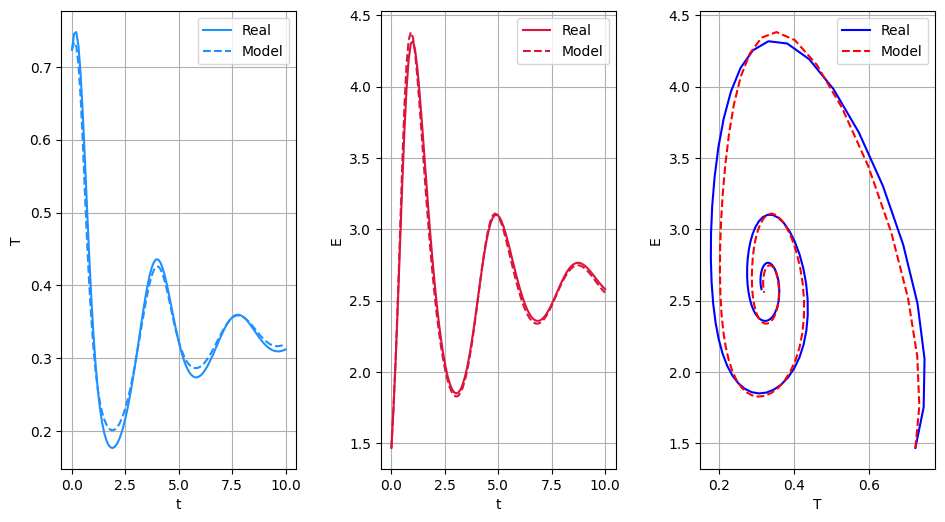

In [ ]:
ts, ys, model = main()

In [ ]:
depths = [1,2,3,4]
width_sizes=[16,32,64,128]
seeds = [2, 3, 5, 7, 11]

In [ ]:
import pandas as pd
df = pd.DataFrame(columns=['error', 'depth', 'width_size', 'seed'])
rows = []
for seed in seeds:
  for depth in depths:
    for width_size in width_sizes:
        ts, ys, model, error, depthn, width_sizen = main(
            dataset_size=256,
            batch_size=32,
            lr_strategy=(3e-3, 3e-3),
            steps_strategy=(1000, 1000),
            length_strategy=(0.1, 1),
            width_size=width_size,
            depth=depth,
            seed=seed,
            plot=False,
            print_every=1000,
        )
        row = {'error': error, 'depth': depth, 'width_size': width_size, 'seed': seed}
        rows.append(row)
df = pd.concat([df, pd.DataFrame(rows)], ignore_index=True)

In [ ]:
df.dtypes
df['error']=df['error'].astype(float)

In [ ]:
df.dtypes
df['seed']=df['seed'].astype(float)

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Establecer un estilo de gráfico
sns.set(style="whitegrid")

# Crear el boxplot
plt.figure(figsize=(14, 8))
ax = sns.boxplot(x='depth', y='error', hue='width_size', data=df, palette="Set3")

# Ajustar las etiquetas y el título
ax.set_title('Boxplot de Error por profundidad y Width Size', fontsize=16)
ax.set_xlabel('Profundidad', fontsize=14)
ax.set_ylabel('Error', fontsize=14)

# Ajustar el tamaño de las etiquetas de los ejes
ax.tick_params(labelsize=12)

# Añadir una cuadrícula
ax.yaxis.grid(True)

# Mover la leyenda fuera de la gráfica
plt.legend(title='Width Size', bbox_to_anchor=(1.05, 1), loc='upper left')

# Usar una escala logarítmica en el eje y
ax.set_yscale('log')

# Ajustar los límites del eje y para enfocar en valores cercanos a cero
ax.set_ylim(bottom=1e-5, top=np.max(df['error']))

# Mostrar el gráfico
plt.tight_layout()
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Establecer un estilo de gráfico
sns.set(style="whitegrid")

# Crear el boxplot
plt.figure(figsize=(14, 8))
ax = sns.boxplot(x='width_size', y='error', hue='depth', data=df, palette="Set3")

# Ajustar las etiquetas y el título
ax.set_title('Boxplot de Error por Width Size y profundidad', fontsize=16)
ax.set_xlabel('Width Size', fontsize=14)
ax.set_ylabel('Error', fontsize=14)

# Ajustar el tamaño de las etiquetas de los ejes
ax.tick_params(labelsize=12)

# Añadir una cuadrícula
ax.yaxis.grid(True)

# Mover la leyenda fuera de la gráfica
plt.legend(title='Profundidad', bbox_to_anchor=(1.05, 1), loc='upper left')

# Usar una escala logarítmica en el eje y
ax.set_yscale('log')

# Ajustar los límites del eje y para enfocar en valores cercanos a cero
ax.set_ylim(bottom=1e-5, top=np.max(df['error']))

# Mostrar el gráfico
plt.tight_layout()
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Crear una tabla dinámica para el heatmap
heatmap_data = df.pivot_table(values='error', index='width_size', columns='depth', aggfunc='mean')

# Encontrar los valores mínimos y máximos para ajustar el rango del heatmap
min_error = heatmap_data.min().min()
max_error = heatmap_data.max().max()

# Crear el heatmap con mayor detalle en los cambios de color
plt.figure(figsize=(12, 10))
ax = sns.heatmap(heatmap_data, annot=True, fmt=".4f", cmap='viridis', cbar_kws={'shrink': 0.8}, vmin=min_error, vmax=max_error)

# Ajustar las etiquetas y el título
ax.set_title('Heatmap de Error por Width Size y profundidad', fontsize=16)
ax.set_xlabel('Profundidad', fontsize=14)
ax.set_ylabel('Width Size', fontsize=14)

# Ajustar el tamaño de las etiquetas de los ejes
ax.tick_params(labelsize=12)

# Mostrar el gráfico
plt.tight_layout()
plt.show()

In [ ]:
df_ordenado = df.sort_values(by='error')

In [ ]:
df_ordenado

In [ ]:
df.to_csv('grid_search.csv', index= False)